<a href="https://colab.research.google.com/github/mdaugherity/MachineLearning2024/blob/main/tutorial/Tutorial_12_Bayesian_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Dr. Daugherity, Abilene Christian University, PHYS 453**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap # for making palettes

# Common utilities
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Classifiers
from sklearn.naive_bayes import GaussianNB

# Extra Math
from scipy.stats import norm
from scipy.stats import multivariate_normal

# Tutorial 12: Bayesian Classifier

Using Kernel (Probability Density) Estimation and Bayesian statistics as a classifier!  Yes, this is a powerful classifier that works really well in certain applications, but it is also a great excuse to study Bayesian stats.

**REFERENCES**
* User Guide: https://scikit-learn.org/stable/modules/naive_bayes.html#gaussian-naive-bayes
* API: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html


# 1-D Examples
Remember that while the math and descriptions are complicated, the approach **really does make sense** once you understand the concepts.  

From Bayes' Theorem   $P(y_i \mid X)  =  \frac{ P(y_i) P(X \mid y_i)} {P(X)}$
we choose the target $i$ that maximizes the posterior probability.  We get $P(X \mid y_i)$ from the training data (and will soon assume it to be Gaussian), and since $P(X)$ is the same for each target (and we don't need a normalized probabilty) we will just ignore it.  

In the simplest case, we can fit each feature to a 1-D Gaussian (this assumes all features are independent)
$P(x_j \mid y) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(x_j - \mu_j)^2}{2\sigma^2}\right)$ for feature $j$, then the combined probabilty for all features is just the product of these 1-D Gaussians.

Some examples will help.

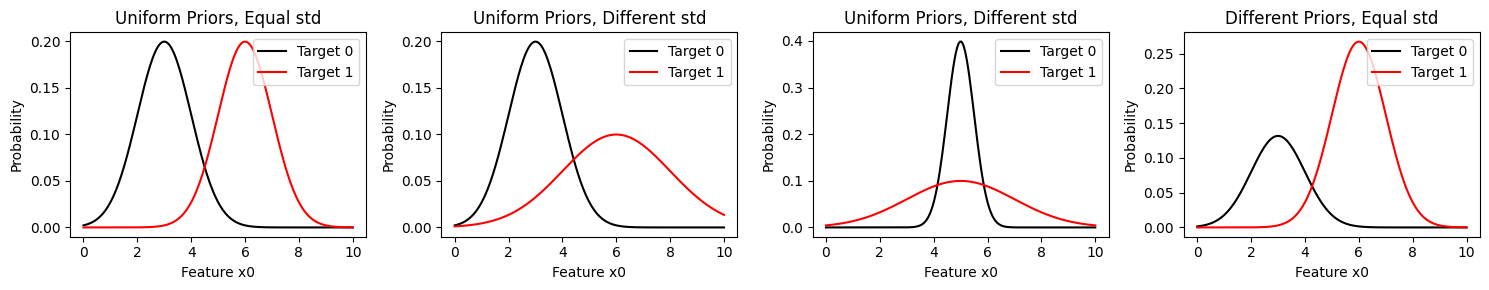

In [ ]:
plt.figure(figsize=(15,3))

# Making a function instead of copying-and-pasting too much code
def makeplot(mu1, std1, mu2, std2, p1, p2, title):
  """make a our gaussian plot with mean mu, standard dev. std, and prior p"""
  xmin = 0
  xmax = 10
  x = np.linspace(xmin, xmax, num=200)
  y1 = p1*norm( mu1, std1).pdf(x) # a Gaussian with mean=3 and std=1
  y2 = p2*norm( mu2, std2).pdf(x)
  plt.plot(x,y1, 'k', label='Target 0')
  plt.plot(x,y2, 'r', label='Target 1')
  plt.xlabel('Feature x0')
  plt.ylabel('Probability')
  plt.title(title)
  plt.legend(loc='upper right')

plt.subplot(1,4,1)
makeplot(3,1,6,1,0.5,0.5,'Uniform Priors, Equal std')

plt.subplot(1,4,2)
makeplot(3,1,6,2,0.5,0.5,'Uniform Priors, Different std')

plt.subplot(1,4,3)
makeplot(5,0.5,5,2,0.5,0.5,'Uniform Priors, Different std')

plt.subplot(1,4,4)
makeplot(3,1,6,1,0.33,0.67,'Different Priors, Equal std')

plt.tight_layout()
plt.show()

The Gaussians represent different targets (e.g. salmon and sea bass).  To classify a new sample, look at which target is most probable.

# Bayesian Classifier with Blobs

Start with the blob dataset from before.  GaussNB will simply fit a gaussian to each class:  
$P(x_j \mid y_i) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(x_j - \mu_j)^2}{2\sigma^2}\right)$  for feature $j$ and target $i$,
and then classify new points as the highest posterior probability


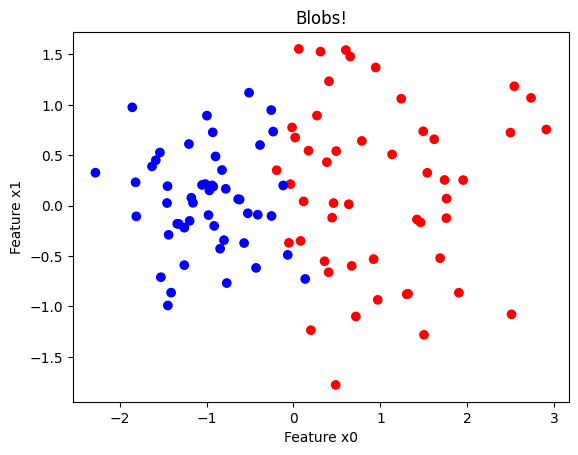

In [ ]:
X_blob, y_blob = datasets.make_blobs(n_samples=100, centers=[[-1,0],[1,0]], cluster_std=[0.5,0.8], n_features=2, random_state=0)

plt.figure()
plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, cmap=plt.cm.bwr)
plt.xlabel("Feature x0")
plt.ylabel("Feature x1")
plt.title("Blobs!")
plt.show()

In [ ]:
# Borrow a color palette from the sklearn example
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

In [ ]:
# Function to plot boundaries: http://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
def plot_decision(model,X,y,cmap_points=cmap_light,cmap_regions=cmap_bold,num=200,margin=1):
  """Plots decision boundary of clf using num points per axis on a grid; margin is extra border padding"""
  x_min, x_max = X[:, 0].min() - margin, X[:, 0].max() + margin
  y_min, y_max = X[:, 1].min() - margin, X[:, 1].max() + margin
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, num),np.linspace(y_min, y_max, num))
  Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)
  plt.pcolormesh(xx, yy, Z, cmap=cmap_regions)
  plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_points,edgecolor='k', s=20)

There are no parameters to choose here.  The decision is which classifier from the naive_bayes model to use.   
https://scikit-learn.org/stable/modules/classes.html#module-sklearn.naive_bayes  
They all make different choices for kernel estimation.  

Training and using GaussNB is really easy

In [ ]:
clf = GaussianNB()
clf.fit(X_blob,y_blob)
print("Training score = ",clf.score(X_blob,y_blob))

Training score =  0.96


We'll make a decision boundary plot just like before.  GaussianNB tends to make parabolic boundaries

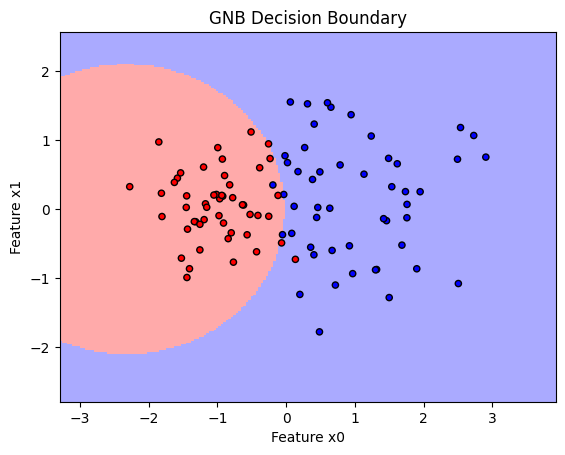

In [ ]:
plt.figure()

plot_decision(clf, X_blob, y_blob, cmap_bold,cmap_light)
plt.xlabel("Feature x0")
plt.ylabel("Feature x1")
plt.title("GNB Decision Boundary")
plt.show()

## Gaussian Fits
GaussNB fits the data points to a gaussian.  We can peek at the fit parameters:

In [ ]:
mu = clf.theta_
vars = clf.var_
print("Means:")
print(mu)
print("Variances:")
print(vars)

Means:
[[-0.99159692  0.05140493]
 [ 0.98502278  0.14619797]]
Variances:
[[0.26505702 0.24193171]
 [0.65787948 0.69941762]]


As always, columns are features.  So the first row is the means for class 0 (blue), and the second row is class 1 (red).

Use the scipy.stats libraries to draw Gaussians:
https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.multivariate_normal.html

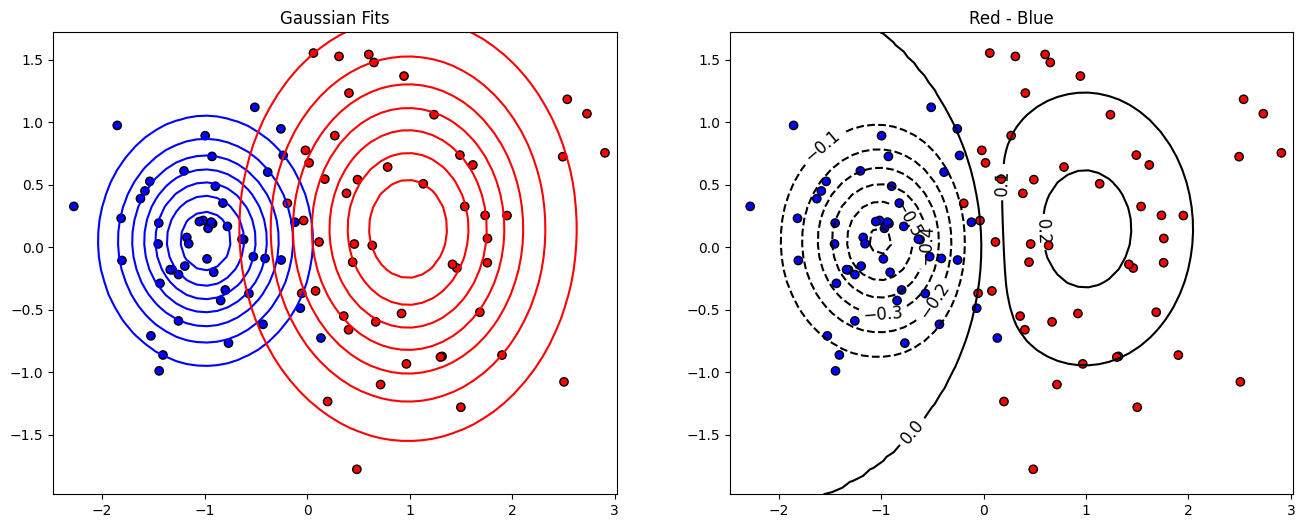

In [ ]:
# Plot the gaussian fits
rv0 = multivariate_normal(mean=mu[0], cov=vars[0])  # declare a 2D gaussian
rv1 = multivariate_normal(mean=mu[1], cov=vars[1])

plt.figure(figsize=(16,6))

# Make a special meshgrid for the 2D gaussian contours
margin=0.2
h=0.1
X = X_blob
x_min, x_max = X[:, 0].min()-margin, X[:, 0].max()+margin
y_min, y_max = X[:, 1].min()-margin, X[:, 1].max()+margin
xx, yy = np.mgrid[x_min:x_max:h, y_min:y_max:h]
pos = np.empty(xx.shape + (2,))
pos[:, :, 0] = xx; pos[:, :, 1] = yy

plt.subplot(1,2,1)
plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, cmap=plt.cm.bwr, ec='k')
L=7
plt.contour(xx, yy, rv0.pdf(pos),colors='blue',levels=L)
plt.contour(xx, yy, rv1.pdf(pos),colors='red',levels=L)
plt.title('Gaussian Fits')

plt.subplot(1,2,2)
plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, cmap=plt.cm.bwr, ec='k')
CS = plt.contour(xx, yy, rv1.pdf(pos)-rv0.pdf(pos),colors='k', levels=8)
plt.clabel(CS, fontsize=12, inline=1)
plt.title('Red - Blue')

plt.show()

**LEFT PLOT:** GaussNB fits each class to a big gaussian.  It does this by finding the mean and variance of each feature and turing that into a 1D gaussian, then the total gaussian is the product of the individual fits.  The red and blue contours show these gaussian fits like a topographical map.  The class priors set the height of each "hill", but in this example the priors are equal.  

**RIGHT PLOT:**  The height of each hill is proportional to the probability of belonging to that class.  To classify a new point, all I need to do is find the heights of each gaussian at my location and choose the biggest one.  For a 2-class case we can visualize this in another way by subtracting the gaussians to find out which one is bigger.  Here I plot red minus blue, so positive heights put me in red territory, and negative heights (dashed contours) are blue.  Notice the contour at Z=0 is the decision boundary.

---
# Iris Dataset
How does GaussNB work on some real data?

In [ ]:
X, y = datasets.load_iris(return_X_y=True)
X2 = X[:,[2,0]]  # only save columns 2 and 0 for making 2-dimensional plots
clf = GaussianNB()
clf.fit(X2,y)
clf.score(X2,y)

0.9133333333333333

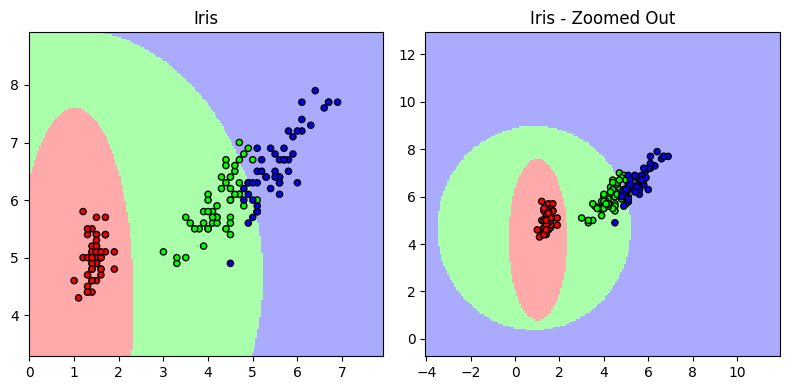

In [ ]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plot_decision(clf, X2, y, cmap_bold, cmap_light)
plt.title("Iris")

plt.subplot(1,2,2)
plot_decision(clf, X2, y, cmap_bold, cmap_light, margin=5)
plt.title("Iris - Zoomed Out")

plt.tight_layout()
plt.show()

Notice that any new point gets classified based on how many standard deviations away it is from the class mean.  

## Prior Probabilites
By default GaussNB measures class priors from the training data, but we can also set them manually.  What happens when we make the green flower more likely?


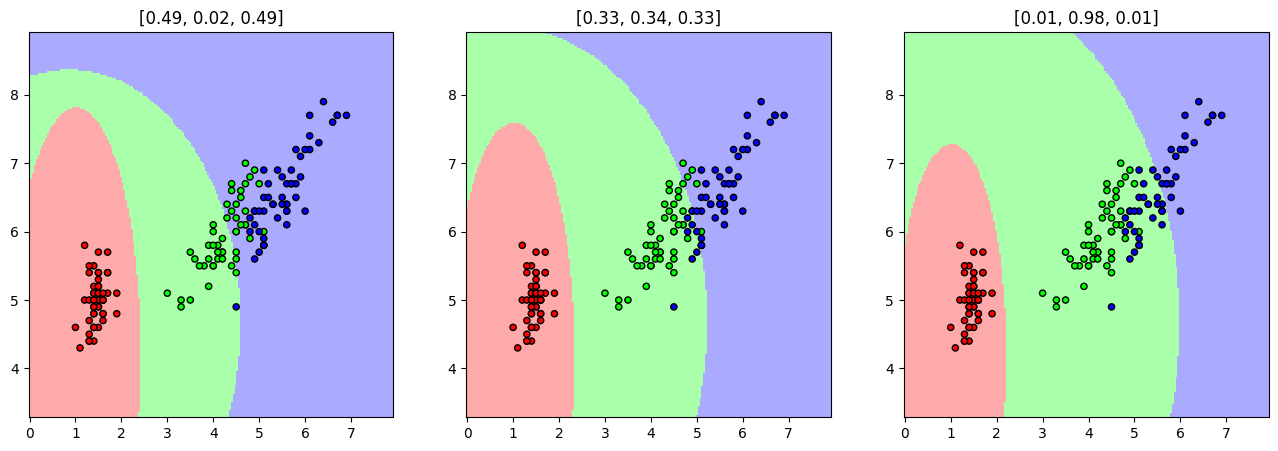

In [ ]:
plt.figure(figsize=(16,5))

priors = [[0.49, 0.02, 0.49], [0.33,0.34,0.33], [0.01,0.98,0.01]]  # order is red,green,blue.  Priors must add to 1
for i in range(3):
    clf = GaussianNB(priors=priors[i])
    clf.fit(X2,y)
    plt.subplot(1,3,i+1)
    plot_decision(clf, X2, y, cmap_bold, cmap_light)
    plt.title(priors[i])

plt.show()

Just for fun, let's do different priors for the blobs

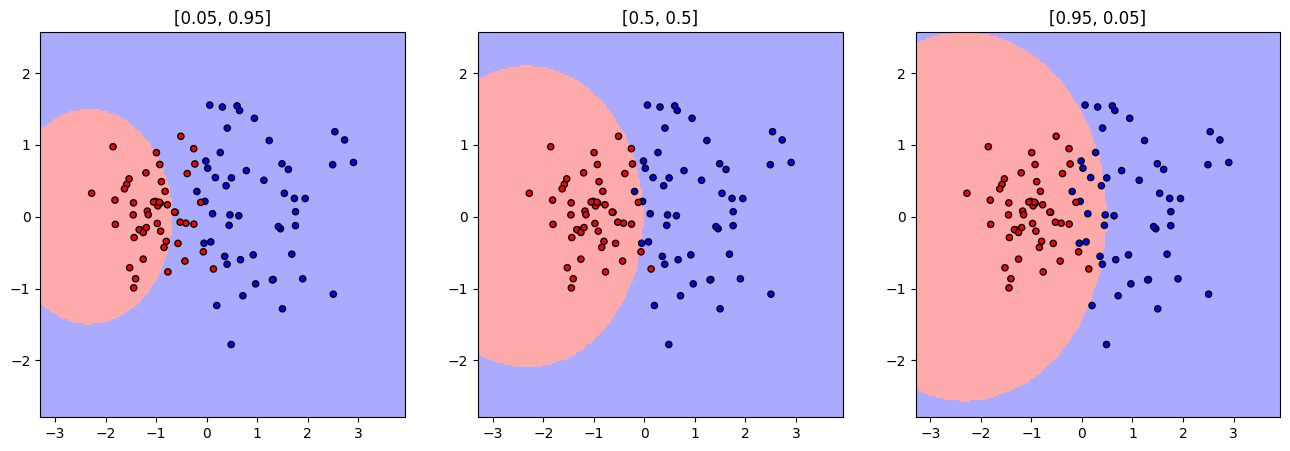

In [ ]:
plt.figure(figsize=(16,5))

priors = [[0.05, 0.95], [0.5,0.5], [0.95,0.05]]
for i in range(3):
    clf = GaussianNB(priors=priors[i])
    clf.fit(X_blob,y_blob)
    plt.subplot(1,3,i+1)
    plot_decision(clf, X_blob, y_blob, cmap_bold,cmap_light)
    plt.title(priors[i])

plt.show()

Remember, priors change the **height** of each gaussian (the Z value coming out of the screen).  By varying the height of the red and blue hills we change the likelihood of being in red or blue territory.  The decision boundary maps the place where red and blue are equal height.

## Gaussian Fits
Let's look under the hood at the Gaussian Fits

In [ ]:
clf = GaussianNB()
clf.fit(X2,y)
clf.theta_   #means

array([[1.462, 5.006],
       [4.26 , 5.936],
       [5.552, 6.588]])

In [ ]:
clf.var_ # variances

array([[0.029556, 0.121764],
       [0.2164  , 0.261104],
       [0.298496, 0.396256]])

In [ ]:
clf.class_prior_

array([0.33333333, 0.33333333, 0.33333333])

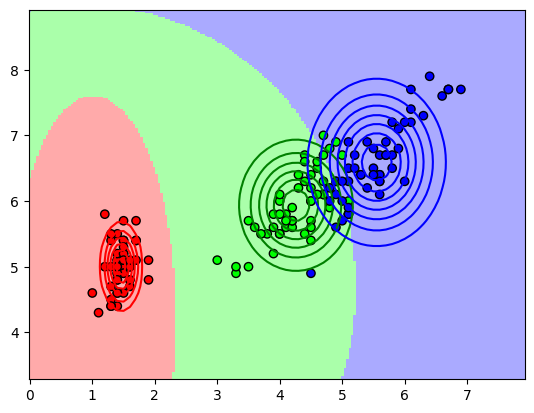

In [ ]:
plt.figure()
mu = clf.theta_
var = clf.var_

rv0 = multivariate_normal(mean=mu[0], cov=var[0])
rv1 = multivariate_normal(mean=mu[1], cov=var[1])
rv2 = multivariate_normal(mean=mu[2], cov=var[2])

# Make a special meshgrid for the 2D gaussian contours
margin=1
h=0.1
x_min, x_max = X2[:, 0].min()-margin, X2[:, 0].max()+margin
y_min, y_max = X2[:, 1].min()-margin, X2[:, 1].max()+margin
xx, yy = np.mgrid[x_min:x_max:h, y_min:y_max:h]
pos = np.empty(xx.shape + (2,))
pos[:, :, 0] = xx; pos[:, :, 1] = yy

plot_decision(clf, X2, y, cmap_bold, cmap_light)
plt.scatter(X2[:,0], X2[:,1], c=y, marker='o', cmap=cmap_bold,edgecolor='k')
plt.contour(xx, yy, rv0.pdf(pos),colors='red')
plt.contour(xx, yy, rv1.pdf(pos),colors='green')
plt.contour(xx, yy, rv2.pdf(pos),colors='blue')

plt.show()

The gaussian peaks describe the iris data fairly well.

# Recipe Setup

In [ ]:
from sklearn.model_selection import cross_validate

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0) # stratify ensures an equal ratio of each target

# Recipe
GNB won't be the best-performing classifier unless every feature happens to be really Gaussian.  It is extremely fast to train and memory efficient, so the best uses are huge problems with lots of features where speed is more important that accuracy.

**References**
* User Guide: https://scikit-learn.org/stable/modules/naive_bayes.html#gaussian-naive-bayes
* API: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html


**Parameters to know**
* None! (But see note below)

**Training Notes**
* By default it will infer the priors from the class distribution in `y`.  You can manually adjust them if you wish.  
* There are literally no parameters you need to adjust, so no grid search is necessary.  We'll just use `cross_validate` to get train and validation scores

In [ ]:
# Define Pipeline
estimators = [('scaler', StandardScaler()), ('clf', GaussianNB()) ]
pipe = Pipeline(estimators)

cv_results = cross_validate(pipe, X_train, y_train, return_train_score=True)

print(f"Training Score\t\t:{cv_results['train_score'].mean():0.3f}")
print(f"Validation Score\t:{cv_results['test_score'].mean():0.3f}")
#print('Best parameters:', grid_clf.best_params_)
#print(f"Best Validation Score:\t{grid_clf.best_score_:0.3f}")

Training Score		:0.962
Validation Score	:0.953
